# AM207 Final Project <br>
# Getting a CLUE: A Method for Explaining Uncertainty Estimates

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2020**<br>

**Team members (in alphabetical order):**

Erik Beerepoot, <erb276@g.harvard.edu> (Interested in Spring research)<br>
Robert Clark, <roc4441@g.harvard.edu> (Interested in Spring research)<br>
Daniel Cox, <daniel_cox@g.harvard.edu><br>
Paul Oramasionwu, <poramasionwu@g.harvard.edu>  (Interested in Spring research)<br>
Austin Rochon, <austinrochon@g.harvard.edu><br>

In [ ]:
from autograd import numpy as np
from autograd import scipy as sp
from autograd import grad, elementwise_grad
from autograd.misc.optimizers import adam, sgd
import autograd.scipy.stats.norm as norm
import numpy
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import os
import gdown
import pickle
import pdb
import base64

# Table of Contents
0. [Introduction](#introduction)<br>
1. [Background](#background)<br>
2. [Technical Content](#technical)<br>
3. [Experiments](#experiments)<br>
4. [Evaluation](#evaluation)<br>
5. [Future Work](#future)<br>
6. [Broader Impact](#broader)<br>








# Supplemental Notebooks

[BNN](./supplemental_notebooks/BNNs.ipynb): Notebook detailing the training of a BNN as part of the clue algorithm<br>
[VAE](./supplemental_notebooks/vae_train.ipynb): Notebook detailing the training of a VAE as part of the clue algorithm and for ground-truth data generation<br>
[VAEAC](./supplemental_notebooks/vaeac.ipynb): Notebook detailing the training of a VAEAC as part for ground-truth data generation<br>


<a name="introduction"></a>
# 0. Introduction

This notebook presents the paper 'Getting a CLUE: A Method for Explaining Uncertainty'. We highlight the salient contents of the paper and provide implementations for the key algorithms and models. Next, we perform experiments with the models and evaluate their performance on several datasets (both synthetic and real). We provide an evaluation of th authors approach and discuss the overall significance and broader impact of the paper. 

<a name="background"></a>
# 1. Background

## 1.1 Problem Statement

The overall goal of the work described in this notebook is to create a useful and actionable way to measure uncertainty estimates. Specifically, the authors seek to understand which regions in the input space of a given problem are responsible for predictive uncertainty by making small changes to the input, keeping it in distribution, so that the model becomes more certain in its decision. This counter-factual approach guarantees explanations have tangible meaning.

## 1.2 Context

Without uncertainty estimates, often times machine learning models are overconfident in their predictions. Depending on the use cases, this can lead to unexpected or even erractic behavior. For this reason there is a growing body of work around estimating model predictive uncertainty. In particular, models such as Bayesian neural networks have been developed to detect when the model is making predictions on out of distribution regions.

In order to make these models more interpretable, the authors believe that it is helpful if a model's predictive uncertainty is expressed in terms of the model input. The authors argue that the method allows us to identify which regions in the training data are sparse. The authors take this a step further by adopting a counter-factual approach by having the model explicitly state which changes to the model input can result in lower predictive undertainty. This makes the model actionable. This can have implications in situations such as loan default prediction and recidivism classification, two highly sensitive areas. The CLUE model can identify sub-populations in the input space that lead to high predictive uncertainty, informing the practitioner that their predictive model can benefit from more training data for these under-represented populations or at least to be able to inform the end-user how much they can rely on the model's predictions. 




## 1.3 Existing Work



### 1.3.1 BNN Uncertainty





An artificial neural network (ANN) is a powerful tool for modeling functional relationships between inputs and outputs. Indeed, in principal such models can implement any parameterized function given a large enough network and enough data and computing power to find the network's optimal weights. For this reason they have in recent years been popularly applied to many predictive tasks. One drawback to ANNs; however, is that they do not yield a distribution of outputs for a given input. That is, traditionally they do not produce an estimate of the uncertainty of their predictions. To address this short coming, Bayesian neural networks (BNNs) were invented in the 1990s [1-5] and have risen in popularity as computing power has increased.  

A Bayesian neural network (BNN) is a Bayesian model for regression or classification that uses a ANN to capture the relationship between inputs $X$ and their corresponding targets $Y$. The output of the neural network, that is its prediction for a given input, appears in the Bayesian model's likelihood function, and the posterior of the model is therefore a probability distribution over the network's weights given the training data.

There are two advantages to a Bayesian neural network over a standard ANN. First, ANNs are prone to overfit and therefore are generally in need of regularization. By providing priors on the network's weights, the Bayesian approach naturally provides some degree of regularization. And second, Baysiean neural networks can be used to estimate the predictive uncertainty in a neural network's prediction for a given input. This is accomplished by repeatedly sampling the model's posterior (probability distribution of weights and biases given the data) and using these samples to determine the model's posterior predictive distribution. This distribution directly reflects the desired uncertainty. In the CLUE algorithm, introduced in the paper we have been examining, the authors use BNNs to estimate predictive uncertainty in neural-network predictions as a precursor to identifying inputs that would lead to less uncertainty.

The greatest challenge in implementing Bayesian neural networks has been finding efficient methods to sample the complex and high-dimensional posteriors typically associated with such models. Two methods are commonly employed, Stochastic Gradient Hamiltonian Monte Carlo, which takes a Markov-Chain-Monte-Carlo sampling approach [3], and Variational Inference, which first approximates the posterior with a simpler function and then samples from it [4,5]. In the experiments we present here we took the Variational Inference approach, which is discussed below in section 2.4.

**References**
1. John Denker and Yann LeCun. Transfroming neural-net output levels to probability distributions. NIPS, 1991

2. David JC MacKay. A practical Bayesian Framework for Backpropagation Networks. Neural Computation 4(3):448-472, 1992

3. Neal, R, M. Bayesian learning via stochastic dynamics. NIPS 1993

4. Geoffrey E. Hinton and Drew Van Camp. Keeping the neural networks simple by minimizing the description length of the weights. COLT, pages 5-13. ACM, 1993

5. David Barber and Christopher M Bishop. Ensemble learning in Bayesian neural networks. In *Generalization in Neural Networks and Machine Learning Springer Verlag*, 215-238, 1998


### 1.3.2 Uncertainty Sensitivity Analysis & Counterfactual explanations

In order to identify in-distribution counterfactuals, we need both the reasons that cause the model to be uncertain and a way to reduce that uncertainty while remaining on the data manifold. According to the authors, related research into quantifying predictive uncertainty has been limited to date, citing a single paper which discusses a linear approximation to quantifying uncertainty in the input space. The authors' main criticism of this approach is twofold: First, linear approximations can often produce non-linear uncertainty estimates (meaning a linear approximation will not be correct). Second, reducing uncertainty directly in a high dimensional input space will not necessarily lead to in-distribution counterfactuals. To remedy these two shortcomings, the authors propose using a variational autoencoder to capture the distribution of input data and optimize an augmented objective taking into account a distance metric in latent space. The use of a generative model constrains the search space to be close to the data manifold.

## 1.4 Contribution 

Discussed in greater detail in section 2.2, the CLUE algorithm is the authors' main contribution to the area of uncertainty estimation. With CLUE, uncertainty is explained in terms of model input allowing a practitioner to determine which input patterns lead to more uncertain outcomes. 

The authors also proposed an approach for evaluating counterfactual explanations of uncertainty. The underlying model, a variational auto-encoder with arbitrary conditioning (VAEAC), is discussed in section 2.2; this model is used to produce ground truth data for the CLUE model. The author claim that this approach provides an effective way to quantify how well the explanations produced by CLUE approximate the true generative process that created the data. This evaluation is discussed in section 2.5.





<a name="technical"></a>
# 2. Technical Content



## 2.1 Overview

CLUE aims to find points in the latent space which generate inputs similar to an original observation, but are assigned low uncertainty. The method leverages the latent space of a deep generative model, specifically a variational autoencoder (VAE), to avoid the challenges associated with working in high dimensional input spaces and to ensure explanations are in-distribution.

As discussed earlier, a VAEAC is used serves as ground truth for the training and evaluation of the CLUE model. This deep generative model, takes a variational autoencoder model but allows the input to be conditioned on any subset of the input features. As stated in the paper, this allows us to jointly model inputs and targets as well as conditional distribution over targets given inputs. The model is used to evaluate if explanations are truly in-distribution.

## 2.2 CLUE Algorithm

The CLUE algorithm aims to find counterfactual data that is similar to our input data but has lower uncertainty. This is done by encoding a latent representation of our input and finding a nearby point in the latent space that reduces uncertainty. Using a lower dimensional latent space to perform this search allows the CLUE to stay in the data distribution. This is because the low-dimensional latent space accounts for correlations between points in the input space.

Intuitively, it is the inputs that change the most between the original input and CLUEs that drive the uncertainty for this given input. The counterfactual examples are also practically useful as an actionable change that would reduce uncertainty in a decision.

The CLUE algorithm takes the following steps after receiving inputs that we would like to generate CLUEs for:
<ol>
<li>Set the initial value of latent representation $z$ by encoding the original input $x$ to $z$
<li>Until convergence do the following:
<ol>
<li>Decode $z$ to input representation $x$
<li>Use the BNN to calculate uncertainty of a prediction for $x$
<li>Calculate distance from $x$ to the original $x$
<li>Update objective function $L$ with uncertainty and distance measures
<li> update $z$ with $\nabla_zL$
</ol>
</ol>

Since we aim to find counterfactual data points that reduce uncertainty, but remain close to our original input, we minimize an objective function made up of two components, uncertainty and distance. 

$$L(z) = H(y|u_\theta(x|z)) + d(u_\theta(x|z),x_0)$$

$u_\theta(x|z)$ is the variational auto encoder's predictive mean of the input given a point in the latent space. In other words it is the output of the VAE decoder.<br>
$H(y|x)$ is the uncertainty in our prediction $y$, given a point in the input space. For classification entropy is the suggested method to quantify uncertainty.<br>

$$H(y|x) = -\sum_{k=1}^K p(y=c_k|x)log \hspace{.1cm} p(y=c_k|x)$$ 

where the classification problem has $K$ classes.<br>
$p(y=c_k|x)$ is the posterior predictive probability that $x$ belongs to class $k$. This value is approximated with the following monte carlo expectation.

$$\frac{1}{M}\sum_{k=1}^Mf(x,w) \hspace{.6cm} w \sim p(w|D)$$

A BNN is used for evaluation of $f(x,w)$ and from this BNN we can generate posterior samples for neural network weights $w$. Averaging over the BNN predictions generated from $M$ weight samples gives us our monte carlo estimate of the posterior predictive probability.

The authors also provide a way to alter the objective function to use aleatoric and/or epistemic uncertainty or a weighted mixture of these and total uncertainty if we have reason to care more about one of these types of uncertainties more than others.

The second component of the objective function is distance. This component measures the similarity of a decoded latent point to the original input.

$$d(x,x_0) = \lambda_xd_x(x,x_0)+\lambda_yd_y(f(x),f(x_0))$$

We use euclidean distance for the distance in input space, $d_x(x,x_0)$ and entropy for distance in the prediction space $d_y(f(x),f(x_0))$. Hyperparameters $\lambda_x$ and $\lambda_y$ control for the trade-off between producing low uncertainty CLUEs and CLUEs that are close to the original inputs.

## 2.3 VAEAC Model

To train our CLUE model, a variational autoencoder with arbitrary conditioning (VAEAC) is first trained on the real data; the VAEAC then serves as the ground truth our CLUE model. The VAEAC is similar to a VAE except now the model may be conditioned on an arbitrary subset of features. The authors argue that since the VAEAC jointly models inputs and targets as well as the conditional distribution over targets given inputs, we can verify if our generated CLUEs are in-distribution.

The evidence of lower bound, ELBO, for a VAEAC is given by:

$$ ELBO_{VAEAC} = E_{q_{\phi}(z|x,b)}logp_{\theta}(x_b|z,x_{1-b},b) - D_{KL}(q_{\phi}(z|x,b)||p_{\psi}(z|x_{1-b},b))$$

While the ELBO for a typically VAE is given by

$$ ELBO_{VAE} = E_{q_{\phi}(z|x)}logp_{\theta}(x|z) - D_{KL}(q_{\phi}(z|x)||p(z))$$

As can be seen, the difference between the $ELBO_{VAE}$ and our $ELBO_{VAEAC}$ that for the VAEAC, we condition a subset of unobserved features, $x_b$, on the remaining $x_{1-b}$ observed features where b is a binary mask. Note that here, the targets are also considered features. During training, a random binary mask is assigned to the data for every iteration of the optimization of the ELBO.

Rather than assume a standard normal for the prior distribution, a prior network is trained in conjuction with encoder and decorder networks. The prior network allows the observed features that we are conditioning on to affect the prior on the latent Gaussian parameters used to generate unobserved features.

Once the VAEAC and CLUE models are trained, the VAEAC can now generate input data for the CLUE model to generate counterfactuals. The VAEAC is used to quantify the aleatoric uncertainty in the produced counterfactual. Also, reduction in epistemic uncertainty is implicitly measured through the reduction in the BNN’s prediction error with respect to the labels outputted by the VAEAC. Finally, the relevance of the counterfactuals is quantified by measuring their likelihood under the VAEAC. These model evaluations are detailed in section 2.5.

Refer to the [vaeac](./supplemental_notebooks/vaeac.ipynb) notebook for details on training the VAEAC<br><br>

**References**
1. Oleg Ivanov, Michael Figurnov and Dmitry Vetrov. Variational Autoencoder with Arbitrary Conditioning. ICLR 2019. https://arxiv.org/abs/1806.02382


## 2.4 Bayesian Neural Networks

In their paper "Getting a CLUE" the authors used Stochastic Gradient Hamaltonian Monte-Carlo sampling to sample the posteriors of their BNNs. However, with our limited computing power we found variational inference to be much less time consuming than the SGHMC approach and more reliable in terms of producing good mappings between $X$ and $Y$. Thus, variational inference was in the end the approach we employed.

Also, to facilitate the training of our BNNs, each BNN was implemented in the Keras-Tensorflow environment ([keras-Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras) ) using what are termed 'flipout' layers ([flipout](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseFlipout), [1]) to perform variational inference. 

Priors for all model weights and biases were gaussian with $\mu=0$, and $\sigma= 0.1$. Cross-entropy was for use for all likelihood calculations. The variational distribution was in each case multivariate gaussian with a diagonal covariance matrix, and stochastic gradient descent was used to minimize the kullback-Leibler Divergence between the true posterior and the variational distribution by way of maximizing the ELBO. A blackbox variational inference algorithm was used to compute an approximation to the gradient of the ELBO for maximization using Monte-Carlo estimation. 


All BNNs we employed had the same architecture: 2 hidden layers with 30 nodes and relu activation, and 1 output layer with a single node and sigmoid activation. We explored other architectures but found that more complex architectures did not improve model accuracy.


After fitting, 1000 samples were drawn from each BNN and stored in such a way that the weights and biases from each sample could be transfered to a BNN of the same architecture but implemented with Autograd [autograd](https://github.com/HIPS/autograd), an automatic differentiation package compatible with our CLUE algorithm. Thus, training was done in the Keras-Tensorflow environment, and then transfer learning was used to run the BNN during the search for CLUEs. 

Refer to the [BNN](./supplemental_notebooks/BNNs.ipynb) notebook for details on training and sampling from the BNNs.

**References**:
1. Yeming Wen, Paul Vicol, Jimmy Ba, Dustin Tran, and Roger Grosse. Flipout: Efficient Pseudo-Independent Weight Perturbations on Mini-Batches. In International Conference on Learning Representations, 2018. https://arxiv.org/abs/1803.04386

## 2.5 Model Evaluations

For a given test point $\bar x_0$ generated by our VAE/VAEAC, the paper defines two paradigms for evaluation:

1. *Informativeness:* The amount of uncertainty that has been explained away by the counterfactual
2. *Relevance:* How close the counterfactuals are to the original inputs.

### Informativeness
To define informativeness, the paper defines metrics to quantify 1) aleatoric and 2) epistemic uncertainty:


*Aleatoric Uncertainty*

Aleatoric uncertainty is defined as the difference in entropy between our ground truth generated test point and its corresponding counterfactual: 

$$\Delta H_{gt} = E \left[ H_{gt}(\bar{x_0}) - H_{gt}(\bar{x_c}) \right]$$

$$\bar{x_0} = \text{ground truth generated test point}$$
$$\bar{x_c} = \text{counterfactual}$$
$$H(x) = \text{aleatoric entropy for a given point}$$

*Epistemic Uncertainty*

Epistemic uncertainty is measured in the reduction in the BNN's prediction accuracy when predicting labels, compared to the ground truth generated test label.

$$\Delta err_{gt} = E \left[ err_{gt}(\bar{x_0}) - err_{gt}(\bar{x_c}) \right]$$

$$\bar{x_0} = \text{ground truth generated test point}$$
$$\bar{x_c} = \text{counterfactual}$$
$$err(x) = \text{the error for the labels outputted by the bnn, compared to gt labels}$$

### Relevance

The paper defines relevance with two metrics: 1) the likelihood of the counterfactuals under the data-generating Deep Generative Model (DGM - in our case, either a VAEAC or VAE), and 2) the distance between the counterfactuals and the original ground truth data generated by the DGM.

*Log-likelihood*

In this paper, the original observed counterfactuals $\bar x_c$ are compared to their corresponding generated samples from the DGM to obtain a likelihood. 
To ensure the high-quality sample generation, samples are drawn from the CLUE VAE's latent space then mapped back to the DGM's inputs space. To do so, we take the latent representation $z$ from the CLUE VAE, then push them through a forward pass of the DGM's decoder. 

*Distance*

To compute a set of counterfactuals "closeness" to the original inputs, the paper uses the simple distance metric below.

$$||\Delta \bar{x}|| = ||\bar{x_0} - \bar{x_c}||$$

$$\bar{x_0} = \text{ground truth generated test point}$$
$$\bar{x_c} = \text{counterfactual}$$


<a name="experiments"></a>
# 3. Experiments

In this section we perform the CLUE algorithm on a few different datasets and analyze the results. Each expirement starts by loading data generated by a VAE or VAEAC. Parameters and neural network structures are loaded from a BNN and VAE that were trained on the generated data. Then we find CLUEs for three inputs that have varying uncertainties as measured by the BNN and analyze the optimization process as well as the resulting CLUEs.

In [ ]:
#Multilayer Perceptron Framework
class MLP:
    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'task': architecture['task']}
 
        # Calculating total number of weights + biases -> self.D
        H = self.params['H']
        num_H = len(H)
        self.num_H = num_H
        D_in = self.params['D_in']
        D_out = self.params['D_out']
        D_H = H
        self.D_H = D_H
        self.D = D_in*H[0] + H[0]
        for i in range(num_H -1):
            self.D += D_H[i] * H[i+1] + H[i+1]
        self.D += D_H[-1]*D_out + D_out
        self.task = self.params['task']
        
         # Initializing weights and biases
        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, np.sqrt(1/self.D), size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))
    
    
    def forward(self, weights, x):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']
        D_H = self.D_H # *

        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            self.N = x.shape[1]
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T


        #input to first hidden layer
        W = weights[:H[0] * D_in].T.reshape((-1, H[0], D_in))
        b = weights[H[0] * D_in:H[0] * D_in + H[0]].T.reshape((-1, H[0], 1))
        input = self.h(np.matmul(W, x) + b)
        # index = H * D_in + H
        index = H[0] * D_in + H[0]

        assert input.shape[1] == H[0]
        
        #additional hidden layers
        for i in range(self.num_H - 1): # *
            before = index
            W = weights[index:index + H[i+1] * D_H[i]].T.reshape((-1, H[i+1], D_H[i]))
            index += H[i+1] * D_H[i]
            b = weights[index:index + H[i+1]].T.reshape((-1, H[i+1], 1))
            index += H[i+1]
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H[i+1]        
            
        #output layer
        W = weights[index:index + H[-1] * D_out].T.reshape((-1, D_out, H[-1]))
        b = weights[index + H[-1] * D_out:].T.reshape((-1, D_out, 1))
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']
        if self.task=='classify':
            return 1 / (1 + np.exp(-output))
        return output


#CLUE Framework
class CLUE:
    def __init__(self, encoder, w_encode, decoder, w_decode, bnn, samples_bt, original_x, desired_preds, uncertainty_weight = 0., aleatoric_weight = 0., epistemic_weight = 0., 
                 prediction_similarity_weight = 0., distance_weight = 0., prob_weight = 0., prob_dist_weight = 0., target_prob = 0.):
                 
      self.encoder = encoder
      self.w_encode = w_encode
      self.decoder = decoder
      self.w_decode = w_decode
      self.bnn = bnn
      self.samples_bt = samples_bt
      self.original_x = original_x
      self.desired_preds = desired_preds
      self.uncertainty_weight = uncertainty_weight 
      self.aleatoric_weight = aleatoric_weight
      self.epistemic_weight = epistemic_weight,
      self.prediction_similarity_weight = prediction_similarity_weight
      self.distance_weight = distance_weight
      self.prob_weight = prob_weight
      self.prob_dist_weight = prob_dist_weight
      self.target_prob = target_prob

    #CLUE Functions

    def decompose_entropy_cat(self, probs, eps=1e-10):
        posterior_mean_probs = np.mean(probs, axis=0) #average over MC samples
        total_entropy = -(posterior_mean_probs * np.log(posterior_mean_probs + eps) + (1-posterior_mean_probs) * np.log(1-posterior_mean_probs + eps)) #calculate entropy for each observation
        sample_probs_entropy = -(probs * np.log(probs + eps) + (1-probs) * np.log((1-probs) + eps)) #entropy for each mc sample 
        aleatoric_entropy = np.mean(sample_probs_entropy,axis=0) #Then average over mc samples
        epistemic_entropy = total_entropy - aleatoric_entropy #The rest of the uncertainty is epistemic
        return total_entropy, aleatoric_entropy, epistemic_entropy

    def uncertainty_from_z(self, z):
        x = self.decoder.forward(self.w_decode, z)[0,:,:] #decode z
        probs = sample_predictions(self.bnn,self.samples_bt,x) #generate MC probabiities using this generated x and BNN MC weights
        total_uncertainty, aleatoric_uncertainty, epistemic_uncertainty = self.decompose_entropy_cat(probs)
        posterior_mean_probs = np.mean(probs,axis=0) #average over MC samples
        return total_uncertainty, aleatoric_uncertainty, epistemic_uncertainty, x, posterior_mean_probs

    #distance in functional space - uses entropy
    def pred_dist(self, y, y_pred, eps=1e-10):
        return -(np.log(y + eps) * y_pred + np.log(1 - y + eps) * (1-y_pred))

    def data_dist(self, x, y):
        d = x - y
        return np.power(np.sum(np.power(d,2),axis=0),0.5)

    def target_dist(self, x, y):
          d = x - y
          return np.power(np.power(d,2),0.5)

    #Posterior Prediction Samples
    def sample_predictions(self, nn, samples, x):
        return nn.forward(samples,x).reshape(samples.shape[0],x.shape[1]) 

    def objective(self, z, for_grad=False):

        obj = 0

        x = self.decoder.forward(self.w_decode, z)[0,:,:] #decode z

        # Uncertainty component
        total_uncertainty, aleatoric_uncertainty, epistemic_uncertainty, x, posterior_mean_probs = self.uncertainty_from_z(z)
        obj += self.uncertainty_weight * total_uncertainty + self.aleatoric_weight * aleatoric_uncertainty + self.epistemic_weight * epistemic_uncertainty

        # posterior mean probability of default
        probs = self.sample_predictions(self.bnn,self.samples_bt,x)
        posterior_mean_probs = np.mean(probs, axis=0)
        obj += self.prob_weight * posterior_mean_probs

        # calculate distance from target probability
        prob_dist = self.target_dist(posterior_mean_probs,self.target_prob)
        obj += self.prob_dist_weight * prob_dist

        # Functional distance component
        prediction_dist = self.pred_dist(posterior_mean_probs,self.desired_preds)
        obj += self.prediction_similarity_weight * prediction_dist

        # Input distance component
        dist = self.data_dist(x, self.original_x)
        obj += self.distance_weight * dist

        if for_grad:
          return obj
        else:
          return obj, total_uncertainty, posterior_mean_probs, dist

    #Define Adam optimizer
    def callback_fn(self, iteration, objective, gradient): 
      if(iteration % 200 == 0):
        print(f"[iteration={iteration}] cost={objective}, gradient={gradient}.")  

    def adam_opt(self, z, num_iters=100,
            step_size=0.001, b1=0.9, b2=0.999, eps=10**-8, callback=True):
    # Adam as described in http://arxiv.org/pdf/1412.6980.pdf
        m = np.zeros(z.shape)
        v = np.zeros(z.shape)

        #initialize tracking metrics
        cost, uncertainty, prob, dist = self.objective(z)

        cost_trace = np.matrix(cost)
        uncertainty_trace = np.matrix(uncertainty)
        probability_trace = np.matrix(prob)
        dist_trace = np.matrix(dist)

        dodz = elementwise_grad(self.objective)

        for i in range(num_iters):

            g = dodz(z, for_grad=True)               
            
            # adam updates
            m = b1 * m + (1-b1) * g
            v = b2 * v + (1-b2) * g ** 2  
            mhat = m / (1 - b1**(i + 1))    # Bias correction.
            vhat = v / (1 - b2**(i + 1))
            z -= step_size*mhat/(np.sqrt(vhat) + eps)
            
            # Get optimization metrics
            cost, uncertainty, prob, dist = self.objective(z)

            if callback:
              self.callback_fn(i, cost, g)

            # Keep track of optimization metrics over time        
            cost_trace = np.vstack((cost_trace, cost))
            uncertainty_trace = np.vstack((uncertainty_trace, uncertainty))
            probability_trace = np.vstack((probability_trace, prob))
            dist_trace = np.vstack((dist_trace, dist))
        
        return z, cost_trace, uncertainty_trace, probability_trace, dist_trace

#Required Functions
relu = lambda x: np.maximum(np.zeros(x.shape), x)

#Posterior Prediction Samples
def sample_predictions(nn,samples,x):
  return nn.forward(samples,x).reshape(samples.shape[0],x.shape[1])

# identify which test observations to find CLUEs for based on their entropy rank within test data
def identify_clues(clues,bnn,samples_bt,x_test,eps=1e-10):
    mc_probs =  sample_predictions(bnn,samples_bt,x_test)
    posterior_mean_probs = np.mean(mc_probs, axis=0) #average over MC samples
    total_entropy = -(posterior_mean_probs * np.log(posterior_mean_probs + eps) + (1-posterior_mean_probs) * np.log(1-posterior_mean_probs + eps))
    clue_idx = np.take((-total_entropy).argsort(),clues) #sort by entropy and take a variety as specified in clues vector
    max_ent_probs = mc_probs[:,clue_idx] #probabilities selected CLUEs
    x_clue = x_test[:,clue_idx] #observed data
    print(clue_idx,'Entropy:',np.round(total_entropy[clue_idx],3),'Probability:',np.round(posterior_mean_probs[clue_idx],2))
    desired_preds = y_test[:,clue_idx][0,:]
    return x_clue, desired_preds

# plot CLUE optimization traceplots
def traceplot(cost_trace,uncertainty_trace,probability_trace,dist_trace,prob_desc = ''):  
    #Plot traces
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30,5))
    # Plot cost function
    ax[0].plot(cost_trace)
    ax[0].set_title("Cost")
    ax[0].legend(loc='upper right',labels = ['CLUE 0','CLUE 1','CLUE 2'])
    # Plot uncertainty 
    ax[1].plot(uncertainty_trace)
    ax[1].set_title("Uncertainty")
    ax[1].legend(loc='upper right',labels = ['CLUE 0','CLUE 1','CLUE 2'])
    # Plot probability
    ax[2].plot(probability_trace)
    ax[2].set_title(prob_desc + " Probability")
    ax[2].legend(loc='upper right',labels = ['CLUE 0','CLUE 1','CLUE 2'])
    # Plot dist function
    ax[3].plot(dist_trace)
    ax[3].set_title("Distance")
    ax[3].legend(loc='upper right',labels = ['CLUE 0','CLUE 1','CLUE 2'])
    return fig, ax

#Print CLUE output
def review_clue(z, x_clue,scaler,decoder,w_decode,bnn,samples_bt,column_names,prob_desc = '',eps=1e-10):
    np.set_printoptions(suppress=True)
    orig_sc = x_clue.T
    orig = pd.DataFrame(np.round(scaler.inverse_transform(orig_sc),2))
    orig.columns = column_names
    print('Original:\n', orig)
    clue_sc = decoder.forward(w_decode, z)[0,:,:].T
    clue = pd.DataFrame(np.round(scaler.inverse_transform(clue_sc),decimals = 2))
    clue.columns = column_names
    print('\nCLUE:\n',clue)

    pct_change = (clue-orig)/orig
    print('\nPercent Change:\n',round(pct_change,2))

    orig_probs =  sample_predictions(bnn,samples_bt,orig_sc.T)
    clue_probs =  sample_predictions(bnn,samples_bt,clue_sc.T)
    posterior_mean_probs_orig = np.mean(orig_probs, axis=0) #average over MC samples
    posterior_mean_probs_clue = np.mean(clue_probs, axis=0) #average over MC samples
    orig_entropy = -(posterior_mean_probs_orig * np.log(posterior_mean_probs_orig + eps) + (1-posterior_mean_probs_orig) * np.log(1-posterior_mean_probs_orig + eps))
    clue_entropy = -(posterior_mean_probs_clue * np.log(posterior_mean_probs_clue + eps) + (1-posterior_mean_probs_clue) * np.log(1-posterior_mean_probs_clue + eps))
    print('\nOrig',prob_desc,'Probability:',np.round(posterior_mean_probs_orig,2))
    print('CLUE',prob_desc, 'Probability:',np.round(posterior_mean_probs_clue,2))
    print('Orig Uncertainty:',np.round(orig_entropy,3))
    print('CLUE Uncertainty:',np.round(clue_entropy,3))
    return orig, clue, orig_probs, clue_probs

## 3.1 Experiment A: Synthetic Loan Default Data Set



We created a fake loan dataset that models covariates as a multivariate normal distribution with realistic correlations. It contains fields that could be used to accept or reject a loan application based on default probability. This first experiment uses three continuous variables: FICO score, loan to value ratio (LTV) which compares the amount of the loan to the value of the asset, and age of the borrower so we can see if the CLUEs suggest change in variables that cannot be immediately changed. This dataset that we created not only allows us to show a few different uses for the CLUE algorithm, but it also helped us understand relationships between the inputs and outputs better as we learned this algorithm.

In [ ]:
#Load Data
def load_file(name):
  with open(name, 'r') as csv_file:
      for line in csv_file:
          line = line.strip('\n')
          b64_str = line.split('|')[2]                    # take the pickled obj
          obj = pickle.loads(base64.b64decode(b64_str))   # retrieve
          return obj

path = './data/FakeLoan_3var_generated/'
name = 'vaeac_generated_data_scaled.csv'
id = '1cc__3qbCc8n14xAtgq7YNvovKIQZyXoz'
if os.path.exists(path + name):
  name = path + name
else: 
  gdown.download('https://drive.google.com/uc?id=' + id, name, quiet=False)

train = load_file(name).T


path = './data/FakeLoan_3var_generated/'
name = 'vaeac_generated_validation_data_scaled.csv'
id = '1DPRQNdmx9V19oyqFOIT-UiGt-OZ8sDCS'
if os.path.exists(path + name):
  name = path + name
else:
  gdown.download('https://drive.google.com/uc?id=' + id, name, quiet=False)
test = load_file(name).T

print(train.shape,test.shape)

#Training Data
loan3v_sc = StandardScaler()
x_train = loan3v_sc.fit_transform(train[:,:-1]).T
y_train = train[:,-1].reshape((1, -1))
#Test Data
x_test = loan3v_sc.transform(test[:,:-1]).T
y_test = test[:,-1].reshape((1, -1))
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

Downloading...
From: https://drive.google.com/uc?id=1cc__3qbCc8n14xAtgq7YNvovKIQZyXoz
To: /content/vaeac_generated_data_scaled.csv
100%|██████████| 42.9k/42.9k [00:00<00:00, 10.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DPRQNdmx9V19oyqFOIT-UiGt-OZ8sDCS
To: /content/vaeac_generated_validation_data_scaled.csv
100%|██████████| 85.8k/85.8k [00:00<00:00, 26.0MB/s]

(1000, 4) (1000, 4)
(3, 1000) (1, 1000) (3, 1000) (1, 1000)


In [ ]:
#Load Model Parameters and Instantiate Models
#BNN
path = './model_parameters/FakeLoan_3var_generated/'
name = 'bnn_samples_VAEAC_loan_3_30_30_1.npy'
id = '1XjOhcGYYlof2ZcoFJ57-3sEv_GT7qwq2'
if os.path.exists(path + name):
  name = path + name
else:
  gdown.download('https://drive.google.com/uc?id='+id, name, quiet=False)
loan3v_samples_bt = np.load(name)

print('bnn probability samples shape: ',loan3v_samples_bt.shape)

loan3v_bnn_architecture = {'width': [30,30],
               'input_dim': 3,
               'output_dim': 1,
               'activation_fn': relu,
               'task': 'classify'}


#VAE
path = './model_parameters/FakeLoan_3var_generated/'
name = 'vae_training_on_vaeac_generated_data.weights'
id = '1fhwjDni2lZujBAIProSvGk2wTfuH15Xv'
if os.path.exists(path + name):
  name = path + name
else:
  gdown.download('https://drive.google.com/uc?id=' + id,name,quiet=False)


#pickle functions
ENCODING_KEY = "encoder_weigths"
DECODING_KEY = "decoder_weigths"
def unpickle_vae_weights(filename):
  """ As if by magic, reverses the pickling process to produce VAE weights """
  with open(filename, "rb") as f:
    weight_dict = pickle.load(f)
    return (weight_dict[ENCODING_KEY], weight_dict[DECODING_KEY])


loan3v_w_encode, loan3v_w_decode = unpickle_vae_weights(name)

print('encoder weight shape: ',loan3v_w_encode.shape)
print('decoder weight shape: ',loan3v_w_decode.shape)

loan3v_input_D = 3
loan3v_latent_D = 2

loan3v_encoder_architecture = {
    "width": [512,256],
    "input_dim": loan3v_input_D,
    "output_dim": loan3v_latent_D * 2,
    'activation_fn': relu,
    'task': 'regression'}

loan3v_decoder_architecture = {
    "width": [512,256],
    "input_dim": loan3v_latent_D,
    "output_dim": loan3v_input_D,
    'activation_fn': relu,
    'task': 'regression'}

#BNN
loan3v_bnn = MLP(loan3v_bnn_architecture)
print('bnn dimension:',loan3v_bnn.D)
#VAE
loan3v_encoder = MLP(loan3v_encoder_architecture)
loan3v_decoder = MLP(loan3v_decoder_architecture)
print('encoder dimension:',loan3v_encoder.D)
print('decoder dimension:',loan3v_decoder.D)

Downloading...
From: https://drive.google.com/uc?id=1XjOhcGYYlof2ZcoFJ57-3sEv_GT7qwq2
To: /content/bnn_samples_VAEAC_loan_3_30_30_1.npy
8.65MB [00:00, 136MB/s]


bnn probability samples shape:  (1000, 1081)


Downloading...
From: https://drive.google.com/uc?id=1fhwjDni2lZujBAIProSvGk2wTfuH15Xv
To: /content/vae_training_on_vaeac_generated_data.weights
100%|██████████| 1.07M/1.07M [00:00<00:00, 108MB/s]

encoder weight shape:  (1, 134404)
decoder weight shape:  (1, 133635)
bnn dimension: 1081
encoder dimension: 134404
decoder dimension: 133635


In [ ]:
loan3v_x_clue, loan3v_desired_preds = identify_clues([0,100,200],loan3v_bnn,loan3v_samples_bt,x_test)

[384 962 295] Entropy: [0.56  0.466 0.394] Probability: [0.25 0.18 0.13]


In [ ]:
# Instantiate Loan Clue Class for Minimizing uncertainty and distance
loan_CLUE = CLUE(encoder = loan3v_encoder, w_encode = loan3v_w_encode, decoder=loan3v_decoder, w_decode = loan3v_w_decode, 
                 bnn = loan3v_bnn, samples_bt = loan3v_samples_bt, original_x = loan3v_x_clue, desired_preds = loan3v_desired_preds,
                distance_weight = 1, uncertainty_weight = 10)

#initialize each observation's encoded mean
z = loan3v_encoder.forward(loan3v_w_encode, loan3v_x_clue)[0,:loan3v_latent_D,:]
#optimize z
z, cost_trace, uncertainty_trace, probability_trace, dist_trace = loan_CLUE.adam_opt(z=z, num_iters = 401, step_size = 1e-2)

[iteration=0] cost=[5.81562652 4.99783518 4.60580817], gradient=[[ 0.32675949 -1.61482555  1.89416628]
 [-0.75519973 -2.78135308 -2.53372024]].
[iteration=200] cost=[3.04684462 3.98066872 1.69609571], gradient=[[-0.12183486 -0.00402127  0.21809509]
 [-0.05011895  0.24999227 -0.03082216]].
[iteration=400] cost=[3.04687232 3.98035567 1.69055344], gradient=[[-0.12324802 -0.00138496  0.03094198]
 [-0.04608624  0.24805852 -0.02661424]].


The traceplots below show the optimization function cost, the uncertainty (entropy) and distance (euclidean) components of the cost function, and the loan default probability during each iteration during the CLUE algorithm.

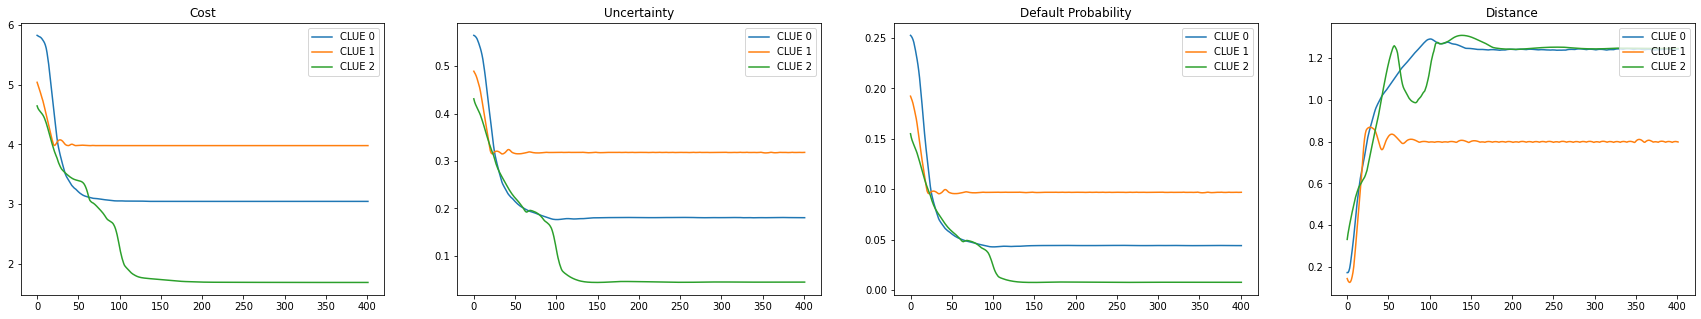

In [ ]:
#Plot optimization traces
fig,ax = traceplot(cost_trace,uncertainty_trace,probability_trace,dist_trace,'Default')
plt.show()

The results below show the original inputs as well as the CLUE we converged to. The percentage change indicates which inputs are driving uncertainty in the original inputs. We also show the start and end default probability and uncertainty.

In [ ]:
# Review CLUEs
orig, clue, orig_probs, clue_probs = review_clue(z, loan3v_x_clue,loan3v_sc,loan3v_decoder,loan3v_w_decode,loan3v_bnn,loan3v_samples_bt,['fico','ltv','age'],'Default')

Original:
      fico   ltv    age
0  584.58  1.16  39.71
1  554.77  1.04  35.76
2  609.17  1.12  46.58

CLUE:
      fico   ltv    age
0  629.84  0.90  41.56
1  547.32  0.93  31.48
2  695.91  0.95  49.70

Percent Change:
    fico   ltv   age
0  0.08 -0.22  0.05
1 -0.01 -0.11 -0.12
2  0.14 -0.15  0.07

Orig Default Probability: [0.25 0.18 0.13]
CLUE Default Probability: [0.04 0.1  0.01]
Orig Uncertainty: [0.56  0.466 0.394]
CLUE Uncertainty: [0.18  0.318 0.044]


There is some change in FICO score, but there is more change in LTV for each CLUE suggesting it is the bigger driver of uncertainty for these observations. Age comes in with the highest percentage change for CLUE 1 indicating it is the largest driver of uncertainty, although it is close with LTV. 

We can also view these results as actionable changes a person could make to lower the uncertainty a bank has for accepting their loan application. However, they can't immediately change age and they certainly cannot reduce their age. We discuss some possible changes to the algorithm in section 5.4 that would help hold certain covariates constant while others change.

For CLUEs 0 and 2, we decrease the uncertainty a lot. Perhaps we want to see if the CLUEs suggest the same features drive uncertainty when the CLUEs are closer to the original input. We can do this by giving more weight to the distance component of the optimization function. We try this below by reducing the uncertainty weight from 10 to 8.

In [ ]:
# Change uncertainty weight from 10 to 5
loan_CLUE = CLUE(encoder = loan3v_encoder, w_encode = loan3v_w_encode, decoder=loan3v_decoder, w_decode = loan3v_w_decode, 
                 bnn = loan3v_bnn, samples_bt = loan3v_samples_bt, original_x = loan3v_x_clue, desired_preds = loan3v_desired_preds,
                distance_weight = 1, uncertainty_weight = 8)

#initialize each observation's encoded mean
z = loan3v_encoder.forward(loan3v_w_encode, loan3v_x_clue)[0,:loan3v_latent_D,:]
#optimize z
z, cost_trace, uncertainty_trace, probability_trace, dist_trace = loan_CLUE.adam_opt(z=z, num_iters = 401, step_size = 1e-2)

[iteration=0] cost=[4.68721766 4.02519183 3.75671887], gradient=[[ 0.18967374 -1.29657273  1.15156304]
 [-0.76290513 -2.47569688 -1.76436218]].
[iteration=200] cost=[4.6486271  3.34425197 2.94190819], gradient=[[ 0.22692852 -0.18785947  0.00188644]
 [-0.13272919 -0.24709303  0.00300063]].
[iteration=400] cost=[4.64880323 3.34388759 2.94190669], gradient=[[ 0.2279549  -0.1836817   0.00173532]
 [-0.13273071 -0.24929631  0.00302245]].


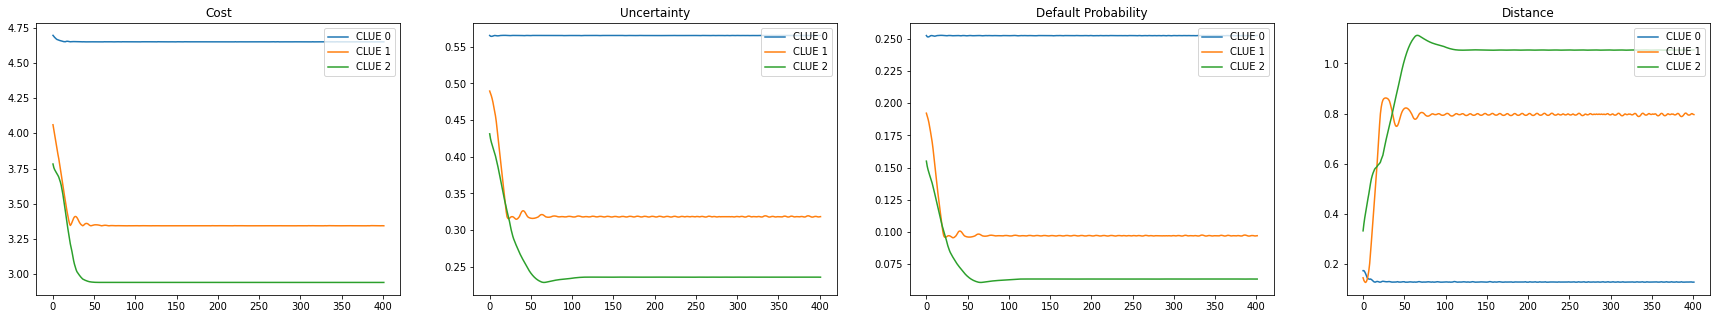

In [ ]:
#Plot optimization traces
fig,ax = traceplot(cost_trace,uncertainty_trace,probability_trace,dist_trace,'Default')
plt.show()

In [ ]:
# Review CLUEs
orig, clue, orig_probs, clue_probs = review_clue(z, loan3v_x_clue,loan3v_sc,loan3v_decoder,loan3v_w_decode,loan3v_bnn,loan3v_samples_bt,['FICO','LTV','age'],'Default')

Original:
      FICO   LTV    age
0  584.58  1.16  39.71
1  554.77  1.04  35.76
2  609.17  1.12  46.58

CLUE:
      FICO   LTV    age
0  586.24  1.15  40.46
1  547.45  0.93  31.49
2  540.40  1.12  51.98

Percent Change:
    FICO   LTV   age
0  0.00 -0.01  0.02
1 -0.01 -0.11 -0.12
2 -0.11  0.00  0.12

Orig Default Probability: [0.25 0.18 0.13]
CLUE Default Probability: [0.25 0.1  0.06]
Orig Uncertainty: [0.56  0.466 0.394]
CLUE Uncertainty: [0.565 0.318 0.236]


Input 2 converges to a CLUE that lowers the distance from the original input and increases the uncertainty compared to the last CLUE run. This is what we were hoping for. However, this slight change in uncertainty weight has caused input 1 to converge to a CLUE that is very close to the original input and results in hardly any uncertainty reduction at all. It seems as though our optimizer (the authors' choice and our choice is ADAM) gets stuck in a local optimum that results from a decline in only distance. The weight change has no effect on CLUE 1.

The weights chosen in this algorithm are arbitrary and seem to result in very different outcomes for different inputs even when the inputs all come from the same data generating function.

In future work section 5.1, we discuss an alternative objective functiont that controls the uncertainty reduction. In future work section 5.3 we discuss other optimization techniques that would do a better job of avoiding local minimum through a greater focus on exploration of the objective function space.

Refer to  [VAEAC.ipynb](./supplemental_notebooks/vaeac.ipynb) for details on training the VAEAC<br>

Refer to  [VAE_3](./supplemental_notebooks/vae_train.ipynb#vae3) for details on training the CLUE VAE <br>

Refer to  [BNN](./supplemental_notebooks/BNNs.ipynb) for details on training and sampling from the BNN for this experiment

## 3.2 Experiment B: Augmented Synthetic Loan Default Data Set



To further show the benefit of working with latent variables to stay in the data distribution, we added two more continuous covariates to our fake loan dataset: the term of the loan and payment to income ratio (PTI) which compares the loan payment to the income generated from the borrower during the same period of time.

In [ ]:
# load data
path = './data/FakeLoan_generated/'
name = 'gen_loan_train_x.csv'
id = '1vJRvog5dCYW84e2SwAFLrrdFUyx2WIxu'
if os.path.exists(path + name):
  name = path + name
else:
  gdown.download('https://drive.google.com/uc?id=' + id,name,quiet=False)

train_x = pd.read_csv(name).loc[:,['fico','term','pti','ltv','age']]

name = 'gen_loan_train_y.csv'
id = '10dI-4h6BW7BhzxMUnURslTJ6NAYrPE64'
if os.path.exists(path + name):
  name = path + name
else:
  gdown.download('https://drive.google.com/uc?id=' + id,name,quiet=False)
  
train_y = pd.read_csv(name).loc[:,'default']

name = 'gen_loan_test_x.csv'
id = '1OBGxyqc4SG1zrPZkN8oQKsym5dVbFA2i'
if os.path.exists(path + name):
  name = path + name
else:
  gdown.download('https://drive.google.com/uc?id=' + id,name,quiet=False)
test_x = pd.read_csv(name).loc[:,['fico','term','pti','ltv','age']]

name = 'gen_loan_test_y.csv'
id = '1raS6jLvP_6GOIIFLd1tGVWiBebZVS8-Q'
if os.path.exists(path + name):
  name = path + name
else:
  gdown.download('https://drive.google.com/uc?id=' + id,name,quiet=False)

test_y = pd.read_csv(name).loc[:,'default']

#Training Data
loan_sc = StandardScaler()
x_train = loan_sc.fit_transform(train_x).T
y_train = train_y.values.reshape((1, -1))
#Test Data
x_test = loan_sc.transform(test_x).T
y_test = test_y.values.reshape((1, -1))
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

Downloading...
From: https://drive.google.com/uc?id=1vJRvog5dCYW84e2SwAFLrrdFUyx2WIxu
To: /content/gen_loan_train_x.csv
100%|██████████| 546k/546k [00:00<00:00, 93.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=10dI-4h6BW7BhzxMUnURslTJ6NAYrPE64
To: /content/gen_loan_train_y.csv
100%|██████████| 68.9k/68.9k [00:00<00:00, 14.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OBGxyqc4SG1zrPZkN8oQKsym5dVbFA2i
To: /content/gen_loan_test_x.csv
100%|██████████| 108k/108k [00:00<00:00, 46.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1raS6jLvP_6GOIIFLd1tGVWiBebZVS8-Q
To: /content/gen_loan_test_y.csv
100%|██████████| 12.9k/12.9k [00:00<00:00, 4.25MB/s]

(5, 10000) (1, 10000) (5, 2000) (1, 2000)


In [ ]:
#Load Model Parameters and Instantiate Models
#BNN
path = './model_parameters/FakeLoan_generated/'
name = 'bnn_samples_VAE_loan_5_30_30_1.npy'
id = '1hMpBZIS23jr8heZKposDoZC-mhBKPU0W'
if os.path.exists(path + name):
  name = path + name
else:
  gdown.download('https://drive.google.com/uc?id='+id, name, quiet=False)
loan_samples_bt = np.load(name)
print('bnn probability samples shape: ',loan_samples_bt.shape)

loan_bnn_architecture = {'width': [30,30],
               'input_dim': 5,
               'output_dim': 1,
               'activation_fn': relu,
               'task': 'classify'}

#VAE
name = 'loan_vae_D_6.weights'
id = '1-F-hv-8o-tGElnUrA0ls9iDU-L4o1SKt' 
if os.path.exists(path + name):
  name = path + name
else:
  gdown.download('https://drive.google.com/uc?id=' + id,name,quiet=False)

#pickle functions
ENCODING_KEY = "encoder_weigths"
DECODING_KEY = "decoder_weigths"

def unpickle_vae_weights(filename):
  """ As if by magic, reverses the pickling process to produce VAE weights """
  with open(filename, "rb") as f:
    weight_dict = pickle.load(f)
    return (weight_dict[ENCODING_KEY], weight_dict[DECODING_KEY])

loan_w_encode, loan_w_decode = unpickle_vae_weights(name)
print('encoder weight shape: ',loan_w_encode.shape)
print('decoder weight shape: ',loan_w_decode.shape)

loan_input_D = 5
loan_latent_D = 3

loan_encoder_architecture = {
    "width": [128,128],
    "input_dim": loan_input_D,
    "output_dim": loan_latent_D * 2,
    'activation_fn': relu,
    'task': 'regression'}

loan_decoder_architecture = {
    "width": [128,128],
    "input_dim": loan_latent_D,
    "output_dim": loan_input_D,
    'activation_fn': relu,
    'task': 'regression'}

#BNN
loan_bnn = MLP(loan_bnn_architecture)
print('bnn dimension:',loan_bnn.D)
#VAE
loan_encoder = MLP(loan_encoder_architecture)
loan_decoder = MLP(loan_decoder_architecture)
print('encoder dimension:',loan_encoder.D)
print('decoder dimension:',loan_decoder.D)  

Downloading...
From: https://drive.google.com/uc?id=1hMpBZIS23jr8heZKposDoZC-mhBKPU0W
To: /content/bnn_samples_VAE_loan_5_30_30_1.npy
9.13MB [00:00, 151MB/s]


bnn probability samples shape:  (1000, 1141)


Downloading...
From: https://drive.google.com/uc?id=1-F-hv-8o-tGElnUrA0ls9iDU-L4o1SKt
To: /content/loan_vae_D_6.weights
100%|██████████| 143k/143k [00:00<00:00, 35.0MB/s]

encoder weight shape:  (1, 18054)
decoder weight shape:  (1, 17669)
bnn dimension: 1141
encoder dimension: 18054
decoder dimension: 17669


In [ ]:
#Identify CLUEs
loan_x_clue, loan_desired_preds = identify_clues([0,300,600],loan_bnn,loan_samples_bt,x_test)

[ 114  535 1926] Entropy: [0.693 0.666 0.557] Probability: [0.5  0.38 0.25]


In [ ]:
# Instantiate Loan Clue Class for Minimizing uncertainty and distance
loan_CLUE = CLUE(encoder = loan_encoder, w_encode = loan_w_encode, decoder=loan_decoder, w_decode = loan_w_decode, 
                 bnn = loan_bnn, samples_bt = loan_samples_bt, original_x = loan_x_clue, desired_preds = loan_desired_preds,
                distance_weight = 1, uncertainty_weight = 5)
#initialize each observation's encoded mean
z = loan_encoder.forward(loan_w_encode, loan_x_clue)[0,:loan_latent_D,:]
#optimize z
z, cost_trace, uncertainty_trace, probability_trace, dist_trace = loan_CLUE.adam_opt(z=z, num_iters = 401, step_size = 1e-2)

[iteration=0] cost=[3.59354595 2.45864037 2.76957373], gradient=[[  6.73082486 -44.2726431  -20.52901937]
 [ -6.01260951   3.25061997  25.98690749]
 [  3.51159253  -5.92925279  -1.74858213]].
[iteration=200] cost=[2.67500168 0.47744861 1.96773242], gradient=[[-4.2951643   0.00068687 -7.00261384]
 [ 4.43251165 -0.00017112  7.5984363 ]
 [-3.94720305  0.00009129 -0.69551672]].
[iteration=400] cost=[2.66878825 0.47744861 1.96370819], gradient=[[ 6.23024502 -0.00000002  4.5925885 ]
 [-5.57566281  0.         -5.48620748]
 [-0.17476754 -0.          2.47820599]].


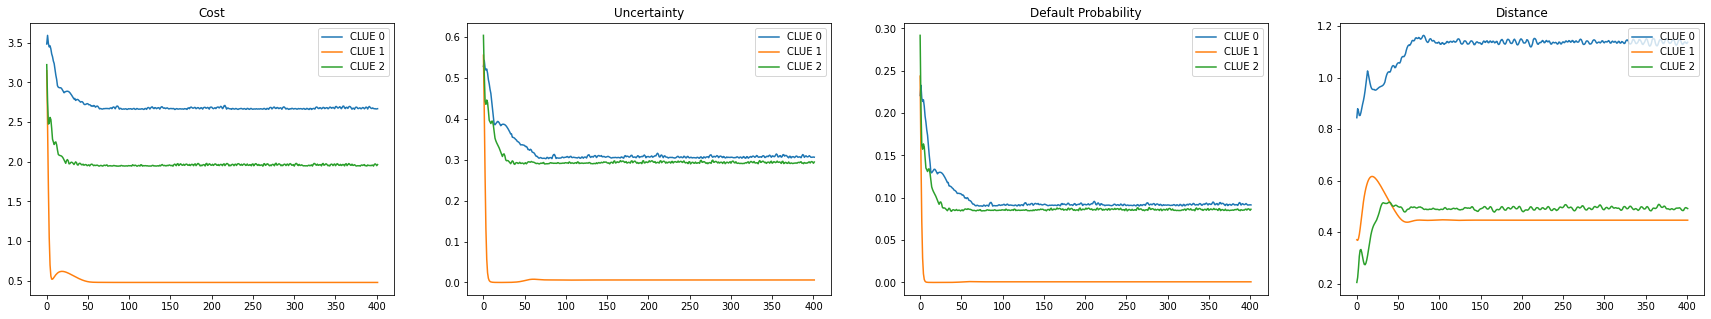

In [ ]:
#Plot optimization traces
fig,ax = traceplot(cost_trace,uncertainty_trace,probability_trace,dist_trace,'Default')
plt.show()

In [ ]:
# Review CLUEs
orig, clue, orig_probs, clue_probs = review_clue(z,loan_x_clue,loan_sc,loan_decoder,loan_w_decode,loan_bnn,loan_samples_bt,train_x.columns,'Default')

Original:
      fico  term   pti   ltv    age
0  429.01  6.48  0.09  1.21  38.48
1  521.31  5.91  0.13  1.10  26.93
2  532.48  7.16  0.08  1.24  36.38

CLUE:
      fico  term   pti   ltv    age
0  501.44  6.98  0.09  1.19  43.33
1  550.38  5.59  0.13  1.09  26.77
2  532.29  7.34  0.06  1.21  35.53

Percent Change:
    fico  term   pti   ltv   age
0  0.17  0.08  0.00 -0.02  0.13
1  0.06 -0.05  0.00 -0.01 -0.01
2 -0.00  0.03 -0.25 -0.02 -0.02

Orig Default Probability: [0.5  0.38 0.25]
CLUE Default Probability: [0.09 0.   0.09]
Orig Uncertainty: [0.693 0.666 0.557]
CLUE Uncertainty: [0.306 0.006 0.294]


CLUE 1 immediately reduces uncertainty to 0 and later in the traceplots we see that it finds its way to a point closer to the original input, but remain at similar uncertainty levels. CLUE 0 and 2 strike a balance between the distance and uncertainty components of the objective function.

Practitioners using this model need to make sure to carefully review CLUEs to make sure they make intuitive sense. CLUE 1 reduces uncertainty to zero with essentially just a slight increase in FICO score and a reduced loan term. BNNs are complex models and it is important to make sure the uncertainty represented by the BNN output is generalized and in line with intuitive expectations.

CLUEs 0 and 2 have less sensitivity to the weights in this problem and we can make slight changes that result in new CLUEs that achieve a different balance between uncertainty and distance. CLUE 1 has similar convergence.

In [ ]:
# Instantiate Loan Clue Class for Minimizing uncertainty and distance
loan_CLUE = CLUE(encoder = loan_encoder, w_encode = loan_w_encode, decoder=loan_decoder, w_decode = loan_w_decode, 
                 bnn = loan_bnn, samples_bt = loan_samples_bt, original_x = loan_x_clue, desired_preds = loan_desired_preds,
                distance_weight = 1, uncertainty_weight = 2)
#initialize each observation's encoded mean
z = loan_encoder.forward(loan_w_encode, loan_x_clue)[0,:loan_latent_D,:]
#optimize z
z, cost_trace, uncertainty_trace, probability_trace, dist_trace = loan_CLUE.adam_opt(z=z, num_iters = 401, step_size = 1e-2)

[iteration=0] cost=[1.96535449 1.20448238 1.24235896], gradient=[[  1.99725802 -18.5432725   -9.0713704 ]
 [ -1.95864449   0.91244218   9.99858824]
 [  0.9236475   -2.39062883  -0.23580824]].
[iteration=200] cost=[1.71208521 0.4503473  1.02207742], gradient=[[-1.59415521 -0.00507723 -2.6985148 ]
 [ 1.57600955  0.00119037  2.95294463]
 [-0.71788171  0.00254048 -0.77600517]].
[iteration=400] cost=[1.70425836 0.45034745 1.02085003], gradient=[[-1.72632253 -0.00497709 -2.78284577]
 [ 1.75912427  0.00138024  3.04673105]
 [-0.73989024  0.00249198 -0.79228405]].


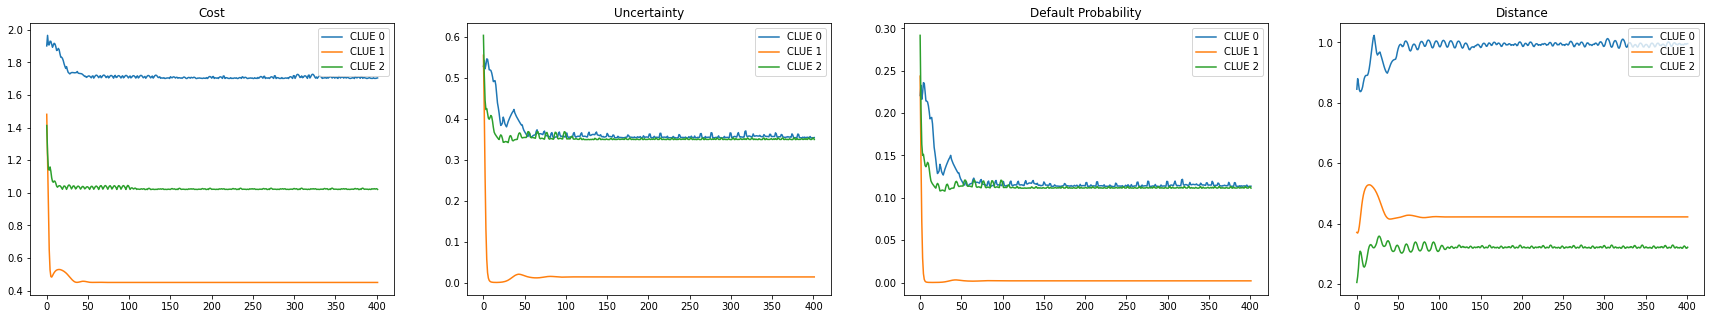

In [ ]:
#Plot optimization traces
fig,ax = traceplot(cost_trace,uncertainty_trace,probability_trace,dist_trace,'Default')
plt.show()

In [ ]:
# Review CLUEs
orig, clue, orig_probs, clue_probs = review_clue(z,loan_x_clue,loan_sc,loan_decoder,loan_w_decode,loan_bnn,loan_samples_bt,train_x.columns,'Default')

Original:
      fico  term   pti   ltv    age
0  429.01  6.48  0.09  1.21  38.48
1  521.31  5.91  0.13  1.10  26.93
2  532.48  7.16  0.08  1.24  36.38

CLUE:
      fico  term   pti   ltv    age
0  494.20  6.94  0.08  1.19  42.27
1  548.24  5.61  0.12  1.09  26.69
2  521.54  7.24  0.07  1.21  36.33

Percent Change:
    fico  term   pti   ltv   age
0  0.15  0.07 -0.11 -0.02  0.10
1  0.05 -0.05 -0.08 -0.01 -0.01
2 -0.02  0.01 -0.12 -0.02 -0.00

Orig Default Probability: [0.5  0.38 0.25]
CLUE Default Probability: [0.11 0.   0.11]
Orig Uncertainty: [0.693 0.666 0.557]
CLUE Uncertainty: [0.354 0.014 0.35 ]


*Analysis of Experiment B:*

Now that we have generated CLUEs for our full loan default dataset, we can evaluate it with the methods described in section 2.5. First, we will define the functions below, which compute the metrics relating to the *informativeness* and *relevance* of  our counterfactuals.

In [ ]:
def compute_error(y_hat_probs, y_true_labs):
  '''
  Computes classification error for a given set of of true labels and 
  predicted probabiities
  '''
  # error storage
  errors = []

  # binarize probabilities
  y_hat_labs = np.where(y_hat_probs > 0.5, 1, 0)

  # match shape of true labels
  y_true_labs = np.tile(y_true_labs, (y_hat_labs.shape[0],1))

  # compute error - there's probably a more efficient way to do this...
  for i in range(y_hat_labs.shape[0]):
    errors.append(1 - accuracy_score(y_true_labs[i], y_hat_labs[i]))
  
  # return y_hat_labs, y_true_labs
  return(np.array(errors))


def compute_clues_likelihood(clue_obj, decoder, z, clue_x_obs, weights):
  '''
  Computes likelihood for a given set of clues by running a forward pass of 
  their latent representation, z, through the generative VAE/VAEAC
  '''
  # fetch input dim from decoder
  latent_dim = decoder.params["D_in"]
  out_dim = decoder.params["D_out"]
  x_var = 1e-2

  # generate x by running a forward pass through the generative decoder using
  # the CLUE observations' latent representation
  clue_x_gt = decoder.forward(weights, z).reshape(out_dim, latent_dim)

  # compute log-likelihood of the observed clue data
  ll = np.mean(np.sum(norm.logpdf(clue_x_obs, clue_x_gt, x_var ** 0.5), axis=-1))

  return ll


def evaluate_clues(clue_obj, orig_probs, clue_probs, orig_data, clue_data, z, x, decoder, decoder_weights):
  '''
  Evaluates CLUEs according to method outlined in section 4 of paper
  '''
  print(f"\n{'='*30}", "\nINFORMATIVENESS METRICS", f"\n{'='*30}")

  ## aleatoric uncertainty
  # ground truth test points 
  _, orig_aleatoric_entropy, _ = clue_obj.decompose_entropy_cat(orig_probs)

  # clue points
  _, clue_aleatoric_entropy, _ = clue_obj.decompose_entropy_cat(clue_probs)

  # compute and report aleatoric uncertainty
  aleatoric = np.mean(orig_aleatoric_entropy - clue_aleatoric_entropy)
  print(f"Aleatoric uncertainty for this batch of CLUEs: {np.round(aleatoric, 4)}")

  ## epistemic uncertainty
  # compute err(x_0), err(x_c)
  err_x0 = compute_error(y_hat_probs=orig_probs, y_true_labs=clue_obj.desired_preds)
  err_xc = compute_error(y_hat_probs=clue_probs, y_true_labs=clue_obj.desired_preds)

  # compute and report epistemic uncertainty
  epistemic = np.mean(err_x0 - err_xc)
  print(f"Epistemic uncertainty for this batch of CLUEs: {np.round(epistemic, 4)}")

  print(f"\n{'='*30}", "\nRELEVANCE METRICS", f"\n{'='*30}")
  
  # compute likelihood
  ll = compute_clues_likelihood(clue_obj, decoder, z, x, decoder_weights)
  print(f"Log likelihood for this batch of CLUES: {ll}\n")

  # compute and report distance in input space
  # distances = clue_obj.data_dist(orig_data, clue_data)
  distances = np.mean(np.abs(orig_data - clue_data))
  print(f"Distance between counterfactuals and ground-truth: \n{np.round(distances, 4)}")



Next, we will load the model parameters for the data-generating deep generative model (DGM - in this case a VAE) and will instantiate the encoder and decoder that generated our synthetic data. 

In [ ]:
# load and define data-generating VAE parameters
path = './model_parameters/FakeLoan_generated/'
name = 'gen_loan_vae_D_6.weights' #TODO - This file names did not exist
id = '1-TG6x-ltX-DyQXbghf2y0GfzI2EnVBxx'

if os.path.exists(path + name):
  name = path + name
else:
  gdown.download('https://drive.google.com/uc?id=' + id, name, quiet=False)

#pickle functions
ENCODING_KEY = "encoder_weigths"
DECODING_KEY = "decoder_weigths"

def unpickle_vae_weights(filename):
  """ As if by magic, reverses the pickling process to produce VAE weights """
  with open(filename, "rb") as f:
    weight_dict = pickle.load(f)
    return (weight_dict[ENCODING_KEY], weight_dict[DECODING_KEY])

gen_loan_w_encode, gen_loan_w_decode = unpickle_vae_weights(name)
print('encoder weight shape: ',gen_loan_w_encode.shape)
print('decoder weight shape: ',gen_loan_w_decode.shape)

gen_loan_input_D = 5
gen_loan_latent_D = 3

gen_loan_encoder_architecture = {
    "width": [128,128],
    "input_dim": gen_loan_input_D,
    "output_dim": gen_loan_latent_D * 2,
    'activation_fn': relu,
    'task': 'regression'}

gen_loan_decoder_architecture = {
    "width": [128,128],
    "input_dim": gen_loan_latent_D,
    "output_dim": gen_loan_input_D,
    'activation_fn': relu,
    'task': 'regression'}

# instantiate generative VAE
gen_loan_encoder = MLP(gen_loan_encoder_architecture)
gen_loan_decoder = MLP(gen_loan_decoder_architecture)
print('encoder dimension:', gen_loan_encoder.D)
print('decoder dimension:', gen_loan_decoder.D)      


Downloading...
From: https://drive.google.com/uc?id=1-TG6x-ltX-DyQXbghf2y0GfzI2EnVBxx
To: /content/gen_loan_vae_D_6.weights
100%|██████████| 143k/143k [00:00<00:00, 55.4MB/s]

encoder weight shape:  (1, 18054)
decoder weight shape:  (1, 17669)
encoder dimension: 18054
decoder dimension: 17669


Finally, we can evaluate this batch of CLUEs. Our aleatoric and epistemic uncertainty figures below represent the respective uncertainties that have *not* been explained by the counterfactual. In other words, they represent the remaining, unexplained uncertainty. The negative epistemic uncertainty metric indicates that this batch of CLUEs had a slightly higher error rate at predicting default when compared to the ground truth observations.

For the relevance metrics, the log-likelihood depicts the likelihood of the observed counterfactuals, given the DGM. Finally, the input distances measure the how close the counterfactuals are to their respective ground-truth inputs which were generated by the DGM.

In [ ]:
# evaluate this batch of CLUEs
evaluate_clues(loan_CLUE, orig_probs, clue_probs, orig, clue, z, loan_x_clue, 
               gen_loan_decoder, gen_loan_w_decode)



INFORMATIVENESS METRICS 
Aleatoric uncertainty for this batch of CLUEs: 0.5231
Epistemic uncertainty for this batch of CLUEs: -0.1547

RELEVANCE METRICS 
Log likelihood for this batch of CLUES: -22.708415325854883

Distance between counterfactuals and ground-truth: 
fico    50.9467
term     0.5200
pti      0.0000
ltv      0.0067
age      2.7100
dtype: float64


Refer to  [VAE_6](./supplemental_notebooks/vae_train.ipynb#vae6) for details on training both the CLUE VAE and data-generating VAE<br>
Refer to  [BNN](./supplemental_notebooks/BNNs.ipynb) for details on training and sampling from the BNN for this experiment

## 3.3 Experiment C: COMPAS Data Set


Our last experiment uses a dataset called COMPAS, which was also used by the authors. COMPAS data contains continuous and discrete covariates and a binary target variable for criminal recidivism. We use most of the same feature engineering that the authors used and ended up with six features: age, race, sex, count of prior crimes, charge degree (felony or misdemeanor), and days served in jail.

In [ ]:
#Load Data
path = './data/COMPAS_generated/'
name = 'gen_compas_train_x.csv'
id = '1VRYjfy50kvv5pgqm0EcYbtOjLM-9TB8w'
if os.path.exists(path + name):
  name = path + name
else:
  gdown.download('https://drive.google.com/uc?id=' + id,name,quiet=False)
train_x = pd.read_csv(name).loc[:,['age','race','sex','priors_count','c_charge_degree','days_served']]


name = 'gen_compas_train_y.csv'
id = '1dLoT7NcBM_IP0YMCSlg_N_ki0aWHwx57'
if os.path.exists(path + name):
  name = path + name
else:
  gdown.download('https://drive.google.com/uc?id=' + id,name,quiet=False)
train_y = pd.read_csv(name).loc[:,'two_year_recid']


name = 'gen_compas_test_x.csv'
id = '1--bQP_Nuc9sk61DKdCHPbbOwEmeN5GOX'
if os.path.exists(path + name):
  name = path + name
else:
  gdown.download('https://drive.google.com/uc?id=' + id,name,quiet=False)
test_x = pd.read_csv(name).loc[:,['age','race','sex','priors_count','c_charge_degree','days_served']]


name = 'gen_compas_test_y.csv'
id = '1hwCX65FjIj-3XyG2G2-W7H2Mtsa9PMzr'
if os.path.exists(path + name):
  name = path + name
else:
  gdown.download('https://drive.google.com/uc?id=' + id,name,quiet=False)
test_y = pd.read_csv(name).loc[:,'two_year_recid']


#Training Data
compas_sc = StandardScaler()
x_train = compas_sc.fit_transform(train_x).T
y_train = train_y.values.reshape((1, -1))

#Test Data
x_test = compas_sc.transform(test_x).T
y_test = test_y.values.reshape((1, -1))
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

Downloading...
From: https://drive.google.com/uc?id=1VRYjfy50kvv5pgqm0EcYbtOjLM-9TB8w
To: /content/gen_compas_train_x.csv
100%|██████████| 688k/688k [00:00<00:00, 83.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dLoT7NcBM_IP0YMCSlg_N_ki0aWHwx57
To: /content/gen_compas_train_y.csv
100%|██████████| 68.9k/68.9k [00:00<00:00, 12.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--bQP_Nuc9sk61DKdCHPbbOwEmeN5GOX
To: /content/gen_compas_test_x.csv
100%|██████████| 137k/137k [00:00<00:00, 24.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hwCX65FjIj-3XyG2G2-W7H2Mtsa9PMzr
To: /content/gen_compas_test_y.csv
100%|██████████| 12.9k/12.9k [00:00<00:00, 9.36MB/s]

(6, 10000) (1, 10000) (6, 2000) (1, 2000)


In [ ]:
#Load Model Parameters and Instantiate Models
#BNN
path = './model_parameters/COMPAS_generated/'
name = 'bnn_samples_VAE_compas_6_30_30_1.npy'
id = '17h-frtm6JRBNnGMqPCPJc_pujKPHOXKC'
if os.path.exists(path + name):
  name = path + name
else:
  gdown.download('https://drive.google.com/uc?id='+id,name,quiet=False)
compas_samples_bt = np.load(name)
print('bnn probability samples shape: ',compas_samples_bt.shape)

compas_bnn_architecture = {'width': [30,30],
               'input_dim': 6,
               'output_dim': 1,
               'activation_fn': relu,
               'task': 'classify'}

#VAE
name = 'compas_vae_D_6_.weights'
id = '1--Eup1esKoF89mlFEmSnzEe58moqHsaJ'
if os.path.exists(path + name):
  name = path + name
else:
  gdown.download('https://drive.google.com/uc?id=' + id,name,quiet=False)

#pickle functions
ENCODING_KEY = "encoder_weigths"
DECODING_KEY = "decoder_weigths"

def unpickle_vae_weights(filename):
  """ As if by magic, reverses the pickling process to produce VAE weights """
  with open(filename, "rb") as f:
    weight_dict = pickle.load(f)
    return (weight_dict[ENCODING_KEY], weight_dict[DECODING_KEY])

compas_w_encode, compas_w_decode = unpickle_vae_weights(name)
print('encoder weight shape: ',compas_w_encode.shape)
print('decoder weight shape: ',compas_w_decode.shape)

compas_input_D = 6
compas_latent_D = 3

compas_encoder_architecture = {
    "width": [128,128],
    "input_dim": compas_input_D,
    "output_dim": compas_latent_D * 2,
    'activation_fn': relu,
    'task': 'regression'}

compas_decoder_architecture = {
    "width": [128,128],
    "input_dim": compas_latent_D,
    "output_dim": compas_input_D,
    'activation_fn': relu,
    'task': 'regression'}

#BNN
compas_bnn = MLP(compas_bnn_architecture)
print('bnn dimension:',compas_bnn.D)
#VAE
compas_encoder = MLP(compas_encoder_architecture)
compas_decoder = MLP(compas_decoder_architecture)
print('encoder dimension:',compas_encoder.D)
print('decoder dimension:',compas_decoder.D)

Downloading...
From: https://drive.google.com/uc?id=17h-frtm6JRBNnGMqPCPJc_pujKPHOXKC
To: /content/bnn_samples_VAE_compas_6_30_30_1.npy
9.37MB [00:00, 167MB/s]


bnn probability samples shape:  (1000, 1171)


Downloading...
From: https://drive.google.com/uc?id=1--Eup1esKoF89mlFEmSnzEe58moqHsaJ
To: /content/compas_vae_D_6_.weights
100%|██████████| 144k/144k [00:00<00:00, 40.8MB/s]

encoder weight shape:  (1, 18182)
decoder weight shape:  (1, 17798)
bnn dimension: 1171
encoder dimension: 18182
decoder dimension: 17798


In [ ]:
#Identify CLUEs
compas_x_clue, compas_desired_preds = identify_clues([0,1100,1500],compas_bnn,compas_samples_bt,x_test)

[  53 1058 1496] Entropy: [0.693 0.655 0.617] Probability: [0.5  0.36 0.69]


In [ ]:
# Instantiate Loan Clue Class for Minimizing uncertainty and distance
compas_CLUE = CLUE(encoder = compas_encoder, w_encode = compas_w_encode, decoder=compas_decoder, w_decode = compas_w_decode, 
                   bnn = compas_bnn, samples_bt = compas_samples_bt, original_x = compas_x_clue, desired_preds = compas_desired_preds,
                distance_weight = 1, uncertainty_weight = 6)
#initialize each observation's encoded mean
z = compas_encoder.forward(compas_w_encode, compas_x_clue)[0,:compas_latent_D,:]
#optimize z
z, cost_trace, uncertainty_trace, probability_trace, dist_trace = compas_CLUE.adam_opt(z=z, num_iters = 401, step_size = 1e-2)

[iteration=0] cost=[4.22190047 4.0001895  3.77046956], gradient=[[ 0.21357703 -0.10448487  0.5023227 ]
 [-0.25935148 -0.13380386  0.22058544]
 [ 0.10714536 -0.03034026  0.25821752]].
[iteration=200] cost=[4.09430295 3.95686443 3.57764307], gradient=[[-0.01847155  0.01639475 -0.00940489]
 [-0.02128517  0.0048303  -0.02081114]
 [-0.04506573  0.02106943  0.00540431]].
[iteration=400] cost=[4.09438058 3.95684725 3.57764352], gradient=[[-0.01593617  0.0216679   0.00280472]
 [-0.01734244  0.01101801  0.00538079]
 [-0.04728228  0.02104734 -0.00114872]].


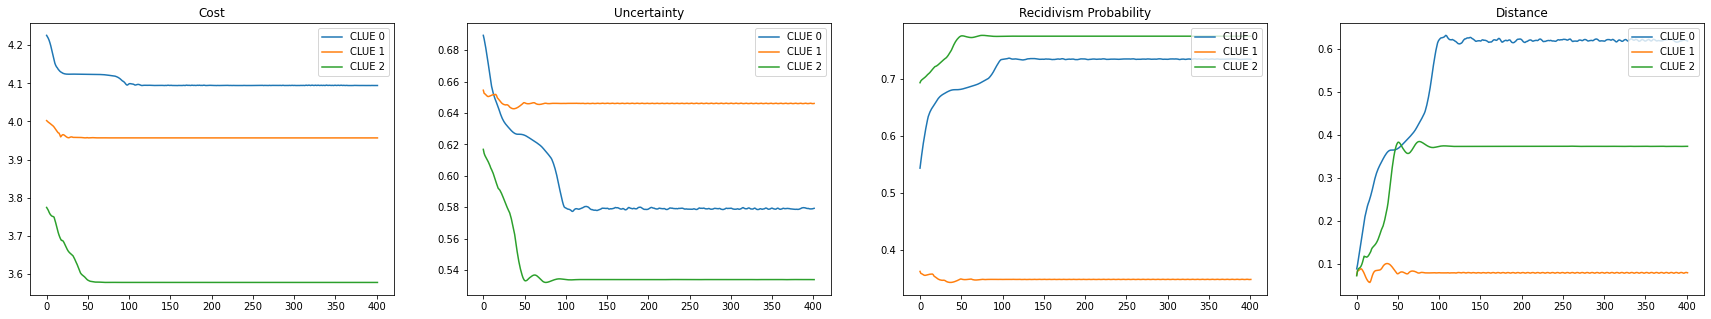

In [ ]:
#Plot optimization traces
fig,ax = traceplot(cost_trace,uncertainty_trace,probability_trace,dist_trace,'Recidivism')
plt.show()

In [ ]:
# Review CLUEs
orig, clue, orig_probs, clue_probs = review_clue(z,compas_x_clue,compas_sc,compas_decoder,compas_w_decode,compas_bnn,compas_samples_bt,train_x.columns,'Recidivism')

Original:
      age  race  sex  priors_count  c_charge_degree  days_served
0  26.96 -0.01  1.0          2.29              1.0         1.33
1  34.59  0.00  1.0          1.25              0.0         1.46
2  27.01 -0.00  1.0          7.86             -0.0         1.31

CLUE:
      age  race   sex  priors_count  c_charge_degree  days_served
0  21.74 -0.02  0.98          3.97             0.99         5.71
1  34.82  0.01  0.99          0.95             0.01         1.58
2  23.77 -0.01  0.99          8.60             0.02         5.64

Percent Change:
     age  race   sex  priors_count  c_charge_degree  days_served
0 -0.19   1.0 -0.02          0.73            -0.01         3.29
1  0.01   inf -0.01         -0.24              inf         0.08
2 -0.12   inf -0.01          0.09             -inf         3.31

Orig Recidivism Probability: [0.5  0.36 0.69]
CLUE Recidivism Probability: [0.73 0.35 0.77]
Orig Uncertainty: [0.693 0.655 0.617]
CLUE Uncertainty: [0.579 0.646 0.534]


We see a similar phenomenon in this experiment as we saw in the loan experiment where some CLUEs have moved away from the original input, while others are stuck in local minima that reduce distance only. 

Unlike loan default probabilities, we have some recidivism probabilities that are greater than 0.5 and the CLUEs reduce uncertainty by increasing recidivism probability. Percentage changes for CLUEs that are well-behaved have the highest percent change in the days served variable. Given the weights we have chosen and the resulting CLUE, we would conclude that days served is driving the uncertainty for these observations.

None of the binary variables race, sex, or c_charge_degree flip. This is good for binary variables like race and sex. A binary variable change requires a CLUE to move the full distance along that dimension which means these will tend to remain the same. Again we do see movement in the continuous age variable.

*Analysis of Experiment C:*

We will also analyze experiment C using the same steps as in experiment B. We will again load the model parameters for the data-generating DGM and will instantiate the encoder and decoder for that network.

In [ ]:
# load and define data-generating VAE parameters
path = './model_parameters/COMPAS_generated/'
name = 'gen_compas_vae_D_6.weights' #compas_vae_D_6_
id = '1-WBpeZFM_uCR-Jf5DLXL99e6tirqvXDQ'

if os.path.exists(path + name):
  name = path + name
else:
  gdown.download('https://drive.google.com/uc?id=' + id, name, quiet=False)

#pickle functions
ENCODING_KEY = "encoder_weigths"
DECODING_KEY = "decoder_weigths"

def unpickle_vae_weights(filename):
  """ As if by magic, reverses the pickling process to produce VAE weights """
  with open(filename, "rb") as f:
    weight_dict = pickle.load(f)
    return (weight_dict[ENCODING_KEY], weight_dict[DECODING_KEY])

gen_compas_w_encode, gen_compas_w_decode = unpickle_vae_weights(name)
print('encoder weight shape: ', gen_compas_w_encode.shape)
print('decoder weight shape: ', gen_compas_w_decode.shape)

gen_compas_input_D = 6
gen_compas_latent_D = 3

gen_compas_encoder_architecture = {
    "width": [128,128],
    "input_dim": gen_compas_input_D,
    "output_dim": gen_compas_latent_D * 2,
    'activation_fn': relu,
    'task': 'regression'}

gen_compas_decoder_architecture = {
    "width": [128,128],
    "input_dim": gen_compas_latent_D,
    "output_dim": gen_compas_input_D,
    'activation_fn': relu,
    'task': 'regression'}

# instantiate generative VAE
gen_compas_encoder = MLP(gen_compas_encoder_architecture)
gen_compas_decoder = MLP(gen_compas_decoder_architecture)
print('encoder dimension:', gen_compas_encoder.D)
print('decoder dimension:', gen_compas_decoder.D)      


Downloading...
From: https://drive.google.com/uc?id=1-WBpeZFM_uCR-Jf5DLXL99e6tirqvXDQ
To: /content/gen_compas_vae_D_6.weights
100%|██████████| 144k/144k [00:00<00:00, 37.9MB/s]

encoder weight shape:  (1, 18182)
decoder weight shape:  (1, 17798)
encoder dimension: 18182
decoder dimension: 17798


The evaluation metrics for the COMPAS dataset are reported below.

In [ ]:
# evaluate this batch of CLUEs
evaluate_clues(compas_CLUE, orig_probs, clue_probs, orig, clue, z, 
               compas_x_clue,  gen_compas_decoder, gen_compas_w_decode)



INFORMATIVENESS METRICS 
Aleatoric uncertainty for this batch of CLUEs: 0.0976
Epistemic uncertainty for this batch of CLUEs: -0.175

RELEVANCE METRICS 
Log likelihood for this batch of CLUES: -1.821568469658116

Distance between counterfactuals and ground-truth: 
age                3.9500
race               0.0167
sex                0.0133
priors_count       1.6100
c_charge_degree    0.0200
days_served        4.2267
dtype: float64


Refer to  [VAE 7](./supplemental_notebooks/vae_train.ipynb#vae7) for details on training both the CLUE VAE and data-generating VAE<br>
Refer to  [BNN](./supplemental_notebooks/BNNs.ipynb) for details on training and sampling from the BNN for this experiment

<a name="evaluation"></a>
# 4. Evaluation



The CLUE algorithm allows balancing between reducing uncertainty and keep counter-factuals on the data manifold. It seems to accomplish this.  We are able to  generate counter-factuals that address the uncertainty. In some cases, the model is sensitive to the objective function weights and a slight change in weights can result in dramatically different CLUEs.

The use of a VAE to work in a lower dimensional space that captures the complex input patterns works very well. The CLUEs produced by this algorithm do seem to stay in the data distribution. The prediction method (BNN) used by this algorithm needs to produce uncertainties that are deemed appropriate by practicioners. Uncertainty output that doesn't make sense would lead to CLUEs that also do not make any sense.

A criticism of the model is that it does not know which inputs are appropriate to change when genetic counter facuals; this is problematic as some input may be impractical or impossible to change. The authors' somewhat account for this by allowing the generation of alternate CLUEs for a given input, by adding gaussian noise to the CLUE initialization. 

Another criticism of the authors' approach, is that it is unclear why a VAEAC is appropriate for the ground truth data. As we've shown in our analysis, a VAE also is capable of capturing the distribution of the data. As stated in the paper, this allows us to jointly model inputs and targets as well as conditional distribution over targets given inputs. A VAE is capable of modeling the inputs and targets; it is unclear why it is important to model the conditional distribution over targers, 

<a name="future"></a>
# 5. Future Work

## 5.1 Target Probability Objective

We saw that in some cases it is difficult to strike a balance to obtain nearby CLUES that move away from the original input, but don't move to the extremes. One way to control this movement is to target a certain probability.

Uncertainty reduction can lead to recidivism probabilities that move higher or lower, but perhaps we want actionable recourse that posits CLUEs that will reduce recidivism probability. For the loan application example a bank may only accept loans when the probability of default is below 30% or maybe a certain interest rate could be achieved if the default probability dropped 5%. In this use case, we could find CLUE counterfactuals that propose nearby changes that would have to be met to achieve these target default probabilities.

We've added some flexibility to the CLUE objective function to target a certain default probability rather than generically reducing uncertainty. By flipping the total uncertainty weight off and flipping on the prob_dist_weight in our CLUE class instantiation we are now minimizing an objective function that replaces total uncertainty with a distance function between the posterior predictive probability and given target probabilities (we've chosen target default probabilites that are 5% lower than input posterior predictive default probabilities. 

In [ ]:
# Instantiate Loan Clue Class to minimize distance to target probability and distance to original input
loan_CLUE = CLUE(encoder = loan_encoder, w_encode = loan_w_encode, decoder=loan_decoder, w_decode = loan_w_decode, 
                 bnn = loan_bnn, samples_bt = loan_samples_bt, original_x = loan_x_clue, desired_preds = loan_desired_preds,
                distance_weight = 1., prob_dist_weight = 12, target_prob = [0.45,0.33,0.2])
#initialize each observation's encoded mean
z = loan_encoder.forward(loan_w_encode, loan_x_clue)[0,:loan_latent_D,:]
#optimize z
z, cost_trace, uncertainty_trace, probability_trace, dist_trace = loan_CLUE.adam_opt(z=z, num_iters = 401, step_size = 5e-4)

[iteration=0] cost=[3.57519751 1.35062444 1.24278963], gradient=[[-16.17483939  89.48298205 -53.13957085]
 [ 13.60447095  -8.90453285  71.49257003]
 [ -9.01143756  12.46648906  -6.05421158]].
[iteration=200] cost=[0.8865884  0.39519017 0.21664522], gradient=[[-81.98882904  81.156425   -32.61162282]
 [ 81.31092841  -9.80750017  47.47687125]
 [-24.28932046  12.14550151  -6.29798935]].
[iteration=400] cost=[0.88219748 0.40181201 0.21473651], gradient=[[-81.94655784  81.48828865 -32.42719622]
 [ 81.27496475  -9.78300876  47.83744691]
 [-24.24788315  12.16625863  -6.38056699]].


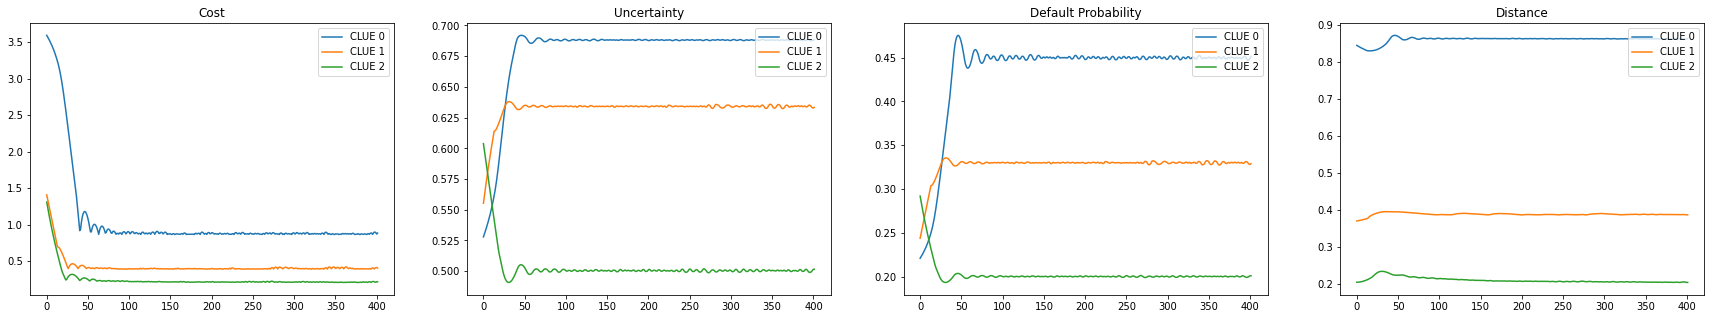

In [ ]:
#Plot optimization traces
fig,ax = traceplot(cost_trace,uncertainty_trace,probability_trace,dist_trace,'Default')
plt.show()

In [ ]:
# Review CLUEs
orig, clue, orig_probs, clue_probs = review_clue(z,loan_x_clue,loan_sc,loan_decoder,loan_w_decode,loan_bnn,loan_samples_bt,['fico','term','pti','ltv','age'],'Default')

Original:
      fico  term   pti   ltv    age
0  429.01  6.48  0.09  1.21  38.48
1  521.31  5.91  0.13  1.10  26.93
2  532.48  7.16  0.08  1.24  36.38

CLUE:
      fico  term   pti   ltv    age
0  485.90  6.96  0.09  1.14  38.92
1  535.14  5.79  0.12  1.05  25.59
2  516.07  7.14  0.08  1.23  36.03

Percent Change:
    fico  term   pti   ltv   age
0  0.13  0.07  0.00 -0.06  0.01
1  0.03 -0.02 -0.08 -0.05 -0.05
2 -0.03 -0.00  0.00 -0.01 -0.01

Orig Default Probability: [0.5  0.38 0.25]
CLUE Default Probability: [0.45 0.33 0.2 ]
Orig Uncertainty: [0.693 0.666 0.557]
CLUE Uncertainty: [0.688 0.633 0.502]


All target default probabilities have been achieved. In the distance traceplot it looks like CLUE 2 is able to make some slight improvement to distance throughout the optimization process.


## 5.2 Multiplicity of Clues

Decisions shouldn't be based on a single CLUE as it is reasonable to believe that there are many counterfactuals that can reduce uncertainty and remain reasonably close to an input. Averaging differences in input over many CLUEs can give us a better idea of which inputs cause uncertainty and this also provides more counterfactual options for actionable change to achieve a more desireable loan approval decision.

In [ ]:
clue_list = []
np.set_printoptions(suppress=True)
orig_sc = loan_x_clue.T
orig = pd.DataFrame(np.round(loan_sc.inverse_transform(orig_sc),2))
orig.columns = ['fico','term','pti','ltv','age']
print('original:\n', orig)
orig_probs =  sample_predictions(loan_bnn,loan_samples_bt,orig_sc.T)
posterior_mean_probs_orig = np.mean(orig_probs, axis=0) #average over MC samples
print('Default Probability:',np.round(posterior_mean_probs_orig,2))
print('\nCLUEs:')
for i in range(3):
  z = loan_encoder.forward(loan_w_encode, loan_x_clue)[0,:loan_latent_D,:] #re-initialize
  z_rand = z + np.random.normal(0,0.1,size=z.shape) #perturbed initialization
  z, cost_trace, uncertainty_trace, probability_trace, dist_trace = loan_CLUE.adam_opt(z=z_rand, num_iters = 401, step_size = 5e-4,callback = False)
  clue_sc = loan_decoder.forward(loan_w_decode, z)[0,:,:].T
  clue = pd.DataFrame(np.round(loan_sc.inverse_transform(clue_sc),decimals = 2))
  clue.columns = ['fico','term','pti','ltv','age']
  print(clue)
  clue_probs =  sample_predictions(loan_bnn,loan_samples_bt,clue_sc.T)
  posterior_mean_probs_clue = np.mean(clue_probs, axis=0) #average over MC samples
  print('Default Probability:',np.round(posterior_mean_probs_clue,2),'\n')
  clue_list.append(clue)

original:
      fico  term   pti   ltv    age
0  429.01  6.48  0.09  1.21  38.48
1  521.31  5.91  0.13  1.10  26.93
2  532.48  7.16  0.08  1.24  36.38
Default Probability: [0.5  0.38 0.25]

CLUEs:
     fico  term   pti   ltv    age
0  508.68  6.88  0.09  1.20  39.50
1  522.21  5.72  0.15  0.92  26.54
2  502.60  7.08  0.08  1.19  37.62
Default Probability: [0.45 0.33 0.2 ] 

     fico  term   pti   ltv    age
0  522.64  6.92  0.07  1.17  40.06
1  539.11  5.83  0.12  1.06  24.58
2  609.28  7.17  0.06  1.17  30.31
Default Probability: [0.45 0.33 0.2 ] 

     fico  term   pti   ltv    age
0  504.90  6.83  0.10  1.20  40.75
1  552.49  5.93  0.11  1.10  24.30
2  514.70  7.17  0.08  1.24  35.20
Default Probability: [0.45 0.33 0.2 ] 



The authors suggest this solution which exploits the non-convexity or CLUE's objective function. They perturb the expected latent representation of the input with gaussian noise. This has the effect of initializing our CLUE search at a different starting point in the latent space. Due to the non-convexity of CLUE's objective function, a different starting point will often times lead us to converge to different CLUE ending points.

In addition to varying starting points for optimization, we may want to also run through a variety of end points or optimization function weights when measuring which inputs uncertainty is coming from. The weights placed on distance and uncertainty reduction is arbitrary. Uncertainty may appear to be driven by one input from CLUEs nearby the original input, while it may appear to be driven by a completely different input when we allow the CLUEs to move further from the original input.

## 5.3 Optimization Techniques

The ADAM optimizer initiated near the original input can easily get stuck in a local minima that are close to the original input, but do not reduce uncertainty. An optimization technique that seems more appropriate for this problem is simulated annealing. The main benefit is it's focus on exploration. We would be able to find many areas in the optimization function space where we do reduce uncertainty and could exploit the balance between uncertainty reduction and distance for these different areas.

A secondary benefit is that it would return a wide variety of CLUES which, as mentioned in the above section, could give us a better idea of which inputs drive uncertainty and provide a wider variety of actionable recourse options.

## 5.4 Conditional CLUEs

There are variables such as age that we cannot immediately change so whether we are finding input patterns that lead to uncertain predictions or generating realistic counterfactual recourse options, it makes sense to condition on certain variables such as a loan applicants age. Working with a conditional vae within the CLUE optimization would give us more control over which inputs we allow to change during the optimization process.

<a name="broader"></a>
# 6. Broader Impact


The potential impact of CLUE depends largely on the chosen application domain. As shown by the authors, CLUE can be applied to a variety of domains with potential impacts ranging from benign to very impactful. For example, if CLUE were to be deployed at a loan-granting institution (akin to the Credit dataset), the actionable recourse that CLUE provides could result in people making changes to their finances in order to improve their chances of getting a loan by reducing the uncertainty in the models assessment. The success of these types of interventions rests heavily on the accuracy of the CLUEs generated. On the other hand, the fact that CLUE can provide insight into otherwise inscrutable models can yield benefits to the end user. Sticking with the loan example, the ability to explain why an algorithm was uncertain about a loan application does allow for actionable recourse.

However, as discussed before, CLUE must be adapted to allow for specifying input that cannot be changed to account for protected attributes and other attributes that are impractical to change. In its current manifestation, CLUE tends to generate counterfactuals in close proximity to high density areas of the data manifold.

Another failure mode of CLUE, is that it relies on accurate estimates of the uncertainty to descend from an area of high uncertainty to an area of low uncertainty. Both the smoothness of the uncertainty and the accuracy can have significant impacts on the generated CLUEs; a lack of smoothness can lead to getting stuck in local minima, a poor uncertainty estimate can lead to counterfactuals that don’t provide appropriate recourse in reality; resulting in the consumers of the technology making unnecessary and potentially difficult changes.